# Lab. 8 - K-Means and the LLoyd algorithm

In this lab we consider the problem of **unsupervised learning**, through one of the most famous **clustering** algorithms: K-means.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy.linalg as la
import scipy.spatial

In [27]:
def mixGauss(means, sigmas, n):
    means = np.array(means)
    sigmas = np.array(sigmas)

    d = means.shape[1]
    num_classes = sigmas.size
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes)

    for idx, sigma in enumerate(sigmas):
        data[idx * n:(idx + 1) * n] = np.random.multivariate_normal(
            mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2, size=n)
        labels[idx * n:(idx + 1) * n] = idx

    if(num_classes == 2):
        labels[labels == 0] = -1

    return data, labels

In [28]:
def all_distances(X1, X2):
    return scipy.spatial.distance.cdist(X1, X2, metric='sqeuclidean')

## Part 1. Implementing the LLoyd Algorithm

The Lloyd algorithm is the standard algorithm for implementing k-means. It is based on two steps
 1. Assigning each point to a cluster
 2. Updating the cluster centers
repeated iteratively until the cluster centers (and point assignments) have converged.

The function skeleton below takes as input the following arguments
 - `X` the data matrix
 - `centers` the initial cluster centers. This could be random, or as we will see in the second part, they could be initialized following a smarter strategy.
 - `maxiter` the maximum number of iterations of the algorithm.

The function returns
 - the final cluster centers
 - the assignment labels of each point to their cluster.

In [32]:
def lloyd(X, centers, maxiter):
    # X: n x d
    # centers : k x d
    n, d = X.shape
    k = centers.shape[0]

    for i in range(maxiter):
        # Compute Squared Euclidean distance (i.e. the squared distance)
        # between each cluster centre and each observation
        dist = all_distances(X, centers) # ... fill here ...

        # Assign data to clusters:
        # for each point, find the closest center in terms of euclidean distance
        c_asg = np.argmin(dist, axis=1)# ... fill here ...

        # Update cluster center
        for c in range(k):
            centers[c] = np.mean(X[c_asg == c], axis=0)# ... fill here ...

    return c_asg, centers

## Part 2. K-Means: Analysis

Here you should create a synthetic dataset using the `mixGauss` function **with four or more classes**.

You can experiment with different dataset creation strategies:
 - Create datasets where the classes are very well separated, then k-means should be able to infer the classes easily
 - Create datasets where the classes have overlap. In this case the k-means algorithm won't be able to distinguish the points of overlap. What do you think will happen?

Then, you should run the k-means algorithm with randomly initialized centers:
 1. Create the random centers **within the same range as your data**. You can use the `np.random.uniform` function for this.
 2. Run the Lloyd algorithm
 3. Plot the results.

##### Your Tasks
You should repeat this procedure multiple times, and comment on the following:
 1. Do you obtain the same clusters every time?
     If you obtain clusterings which are always the same, you can try to initialize two cluster centers at a very similar point. This will put the algorithm in a difficult situation!
     
 2. Why do the colors of a specific cluster seem to change at each iteration?
 3. Try using the *wrong* number of clusters `k` (wrong with respect to the number of classes you used to generate the data). What happens?

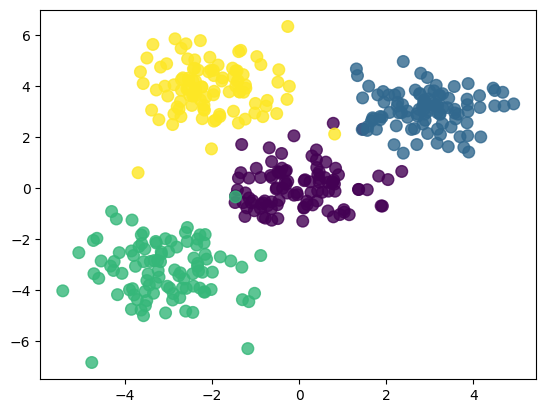

In [33]:
# Build a dataset with at least 4 classes in 2 dimensions, and plot it
X, Y = mixGauss(means = [[0, 0], [3, 3], [-3, -3], [-2, 4]], sigmas = [0.9, 0.75, 1.0, 0.85], n=100)# ... fill here ...
plt.scatter(X[:,0], X[:,1], s=70, c=Y, alpha=0.8)

c:\Users\ftame\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


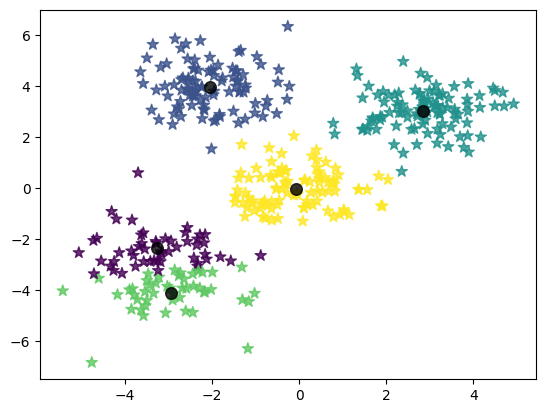

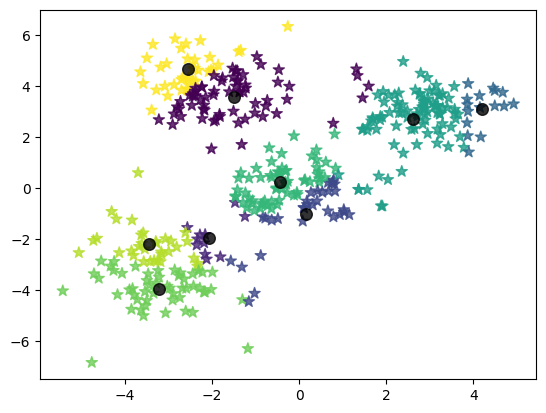

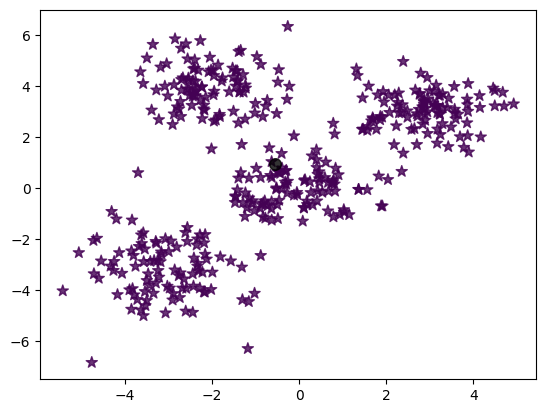

In [34]:
# Try with a random initialization of the centers.
k = 5# ... fill here ...
centers0 = np.random.uniform(low=np.amin(X, 0), high=np.amax(X, 0), size=(k, X.shape[1]))

# Call the lloyd function
Iv, centers = lloyd(X, centers0, 10)# ... fill here ...

# Visualize the final clusters and their centroids
plt.scatter(X[:,0], X[:,1], s=70, c=Iv, marker='*', alpha=0.8)
plt.scatter(centers[:,0], centers[:,1], s=70, c='k', alpha=0.8)

# NOTE: TRY MULTIPLE TIMES!
k = 10
centers0 = np.random.uniform(low=np.amin(X, 0), high=np.amax(X, 0), size=(k, X.shape[1]))
Iv, centers = lloyd(X, centers0, 1)

plt.figure()
plt.scatter(X[:,0], X[:,1], s=70, c=Iv, marker='*', alpha=0.8)
plt.scatter(centers[:,0], centers[:,1], s=70, c='k', alpha=0.8)

k = 50
centers0 = np.random.uniform(low=np.amin(X, 0), high=np.amax(X, 0), size=(k, X.shape[1]))
Iv, centers = lloyd(X, centers0, 100)

plt.figure()
plt.scatter(X[:,0], X[:,1], s=70, c=Iv, marker='*', alpha=0.8)
plt.scatter(centers[:,0], centers[:,1], s=70, c='k', alpha=0.8)

<h3>Comments</h3>

1. The clusters are different from each other:
- First plot: the data points are grouped in different clusters, characterized by different colors. The black dots represent the final centroids.
- Second plot: the representation is similar, but there are different clusters.
- Third plot: since there is a high number of centroids, the points are into one cluster, with only a few points correctly assigned.
     
2. The colors of a specific cluster seem to change at each iteration because there is random initialization of the centroids.

3. As we can see from the third plot, the choice of $k$ is crucial to implement everything correctly: $k=50$ is too large, so the clusters are all merged into a single one.

## Part 3. A Better Initialization Strategy: K-Means++

Initializing the cluster centers at random, sometimes makes the algorithm converge to a sub-optimal local minimum.

The k-means++ algorithm is an **initialization strategy** to generate the initial centers, which can then be passed to the lloyd algorithm.

K-means++ works by selecting the cluster centers as the points within the dataset which have the **maximum distance** between each other. To do this it uses a greedy strategy implemented in the `kmeanspp` function below.

Take a look at the K-Means++ function and then use it as initialization for the K-means algorithm.

##### Your task:
You should take a dataset on which K-Means was struggling, and apply K-Means++ for the center initialization, trying to show that the new initialization strategy improves the clustering algorithm.

In [36]:
def kmeanspp(X, k):
    n, d = X.shape

    IdxC = np.random.permutation(n)
    centers = np.zeros((k, d))

    # Select a random point in the dataset as the starting point
    centers[0, :] = X[IdxC[0], :]

    for i in range(1, k):
        D = all_distances(centers[:i, :], X)
        Ds = np.min(D, axis=0)  # This is the distance to the closest existing center

        # Probability of choosing new points as centers is weighted as the
        # squared distance to the closest existing center.
        D2 = Ds ** 2
        P = np.divide(D2, np.sum(D2))

        # Simply pick the point with the highest probability
        newcpos = np.argmax(P)
        centers[i,:] = X[newcpos, :]
    return centers

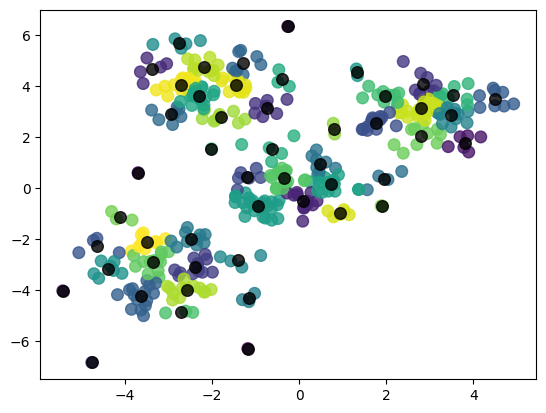

In [38]:
# Try and use K-Means++ for initialization
k = 50# ... fill here ...
centers0 = kmeanspp(X, k)# ... fill here ...

# Call the Lloyd function
Iv, centers = lloyd(X, centers0, 100)# ... fill here ...

# Visualize the final clusters and their centroids
plt.scatter(X[:,0], X[:,1], s=70, c=Iv, alpha=0.8)
plt.scatter(centers[:,0], centers[:,1], s=70, c='k', alpha=0.8)

As expected, the initialization was important: with K-Means++ the centroid are ensured to be far, therefore having a more distinct clustering.